### Part 3. AI Agent 심화 프로젝트

Chapter 03. GraphRAG

📒[실습] Clip 07. Vector + Graph RAG 구현하기🗒️
텍스트 기반으로 노드를 찾고(vector search) 그 주변의 노드들 까지 함께 맥락으로 볼 때 필요
- 이번 예시에선 영화 노드의 줄거리를 embedding하여 검색하고, 그 주변 노드를 그래프 순회를 하여 추가 맥락을 제공하는 방식으로 구현 예정


🔗 Graph DB 연결하기
영화 추천 데이터셋 : https://github.com/neo4j-graph-examples/recommendations

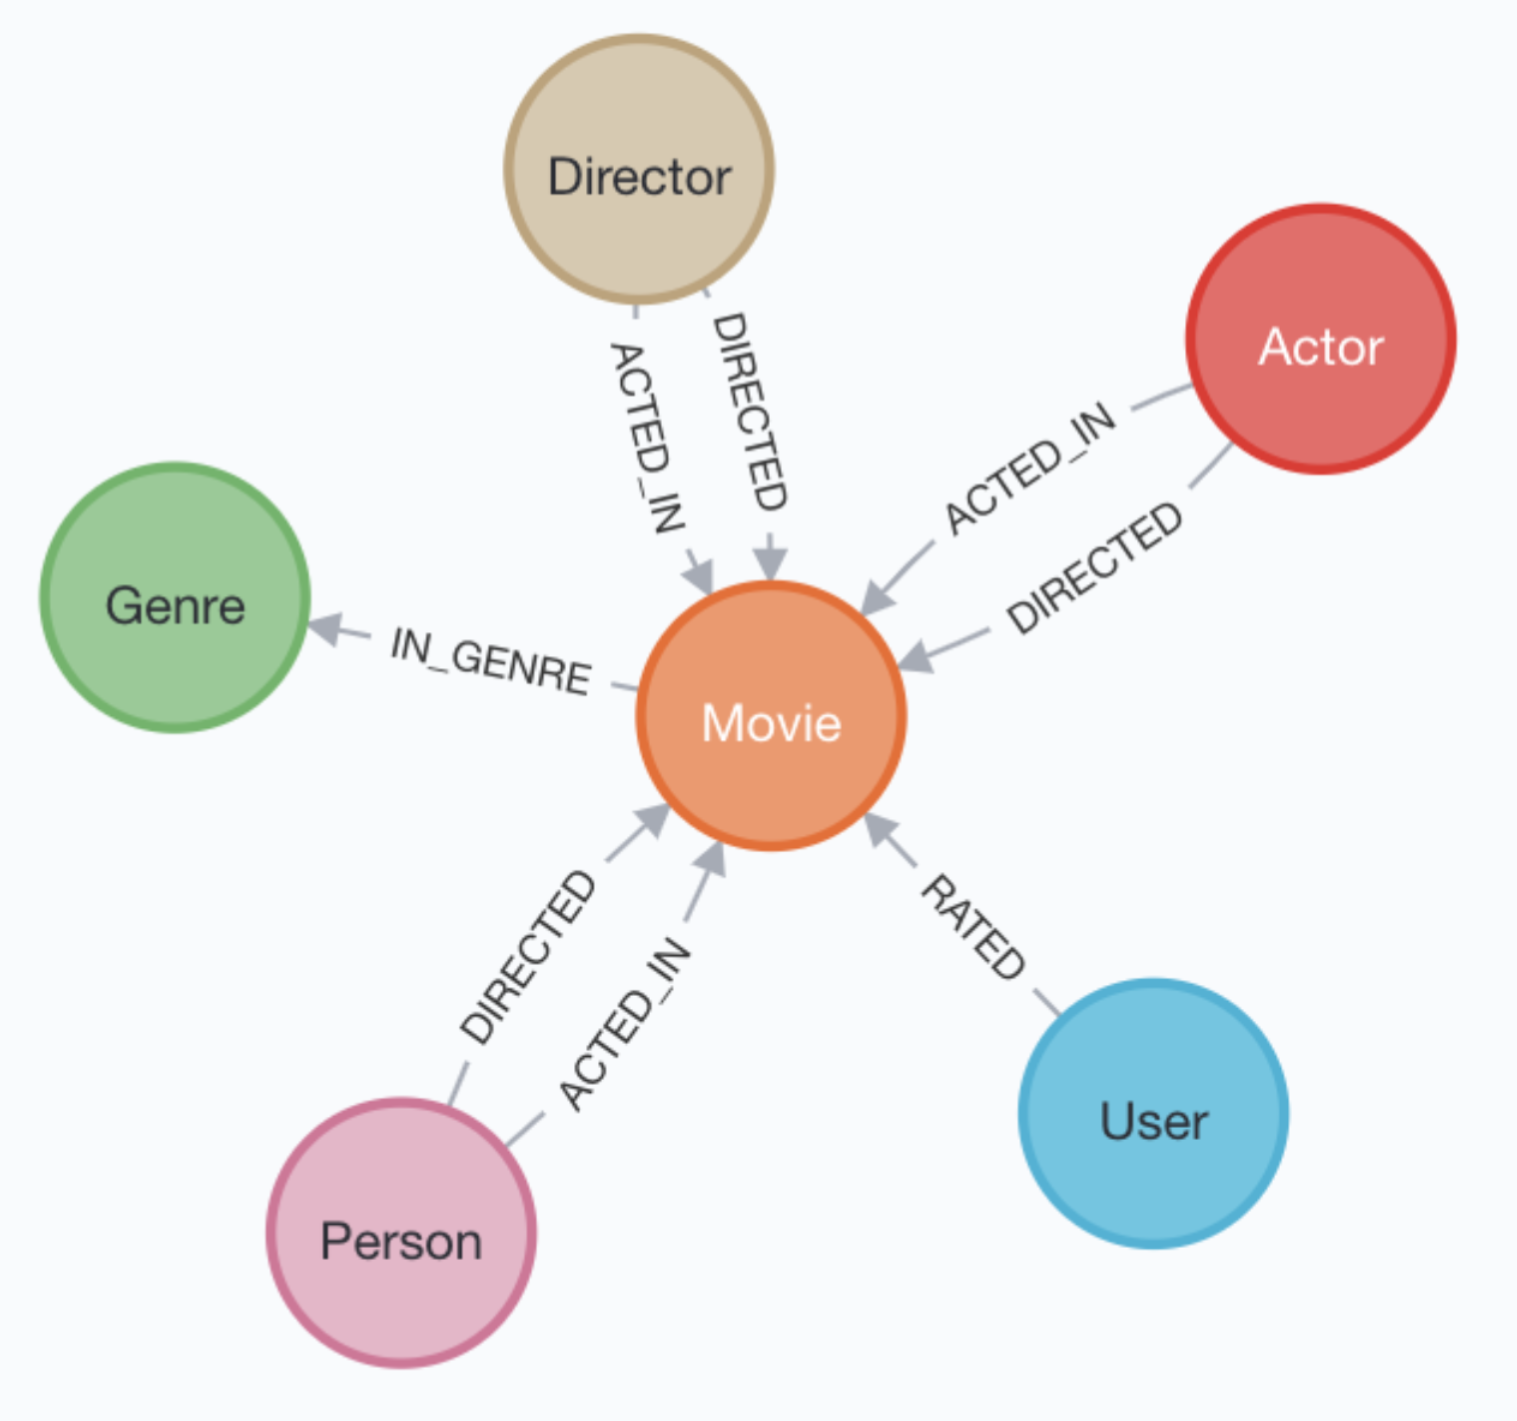

### 1.Aura DB(클라우드 DB에 DataSet을 집어 넣어서)

In [ ]:
from neo4j import GraphDatabase

URI = "neo4j+s://your-database-uri"
AUTH = ("your-username", "your-password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

### 2.Sandbox : https://github.com/neo4j-graph-examples/recommendations
- 온라인상에서 바로 사용

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j://44.197.170.109:7687"
AUTH = ("neo4j", "nineties-breaks-preservers")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [ ]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

## 🧑‍💻 Vector + Graph 기반 RAG 구현하기
### 1️⃣ Embedding, Vector INDEX 추가하기

In [ ]:
from neo4j_graphrag.embeddings.sentence_transformers import SentenceTransformersEmbeddings

# 비용 안들이고 임베딩 할 때
embedder = SentenceTransformersEmbeddings(model_name="all-MiniLM-L6-v2")

movie 노드의 plot을 임베딩한 모습

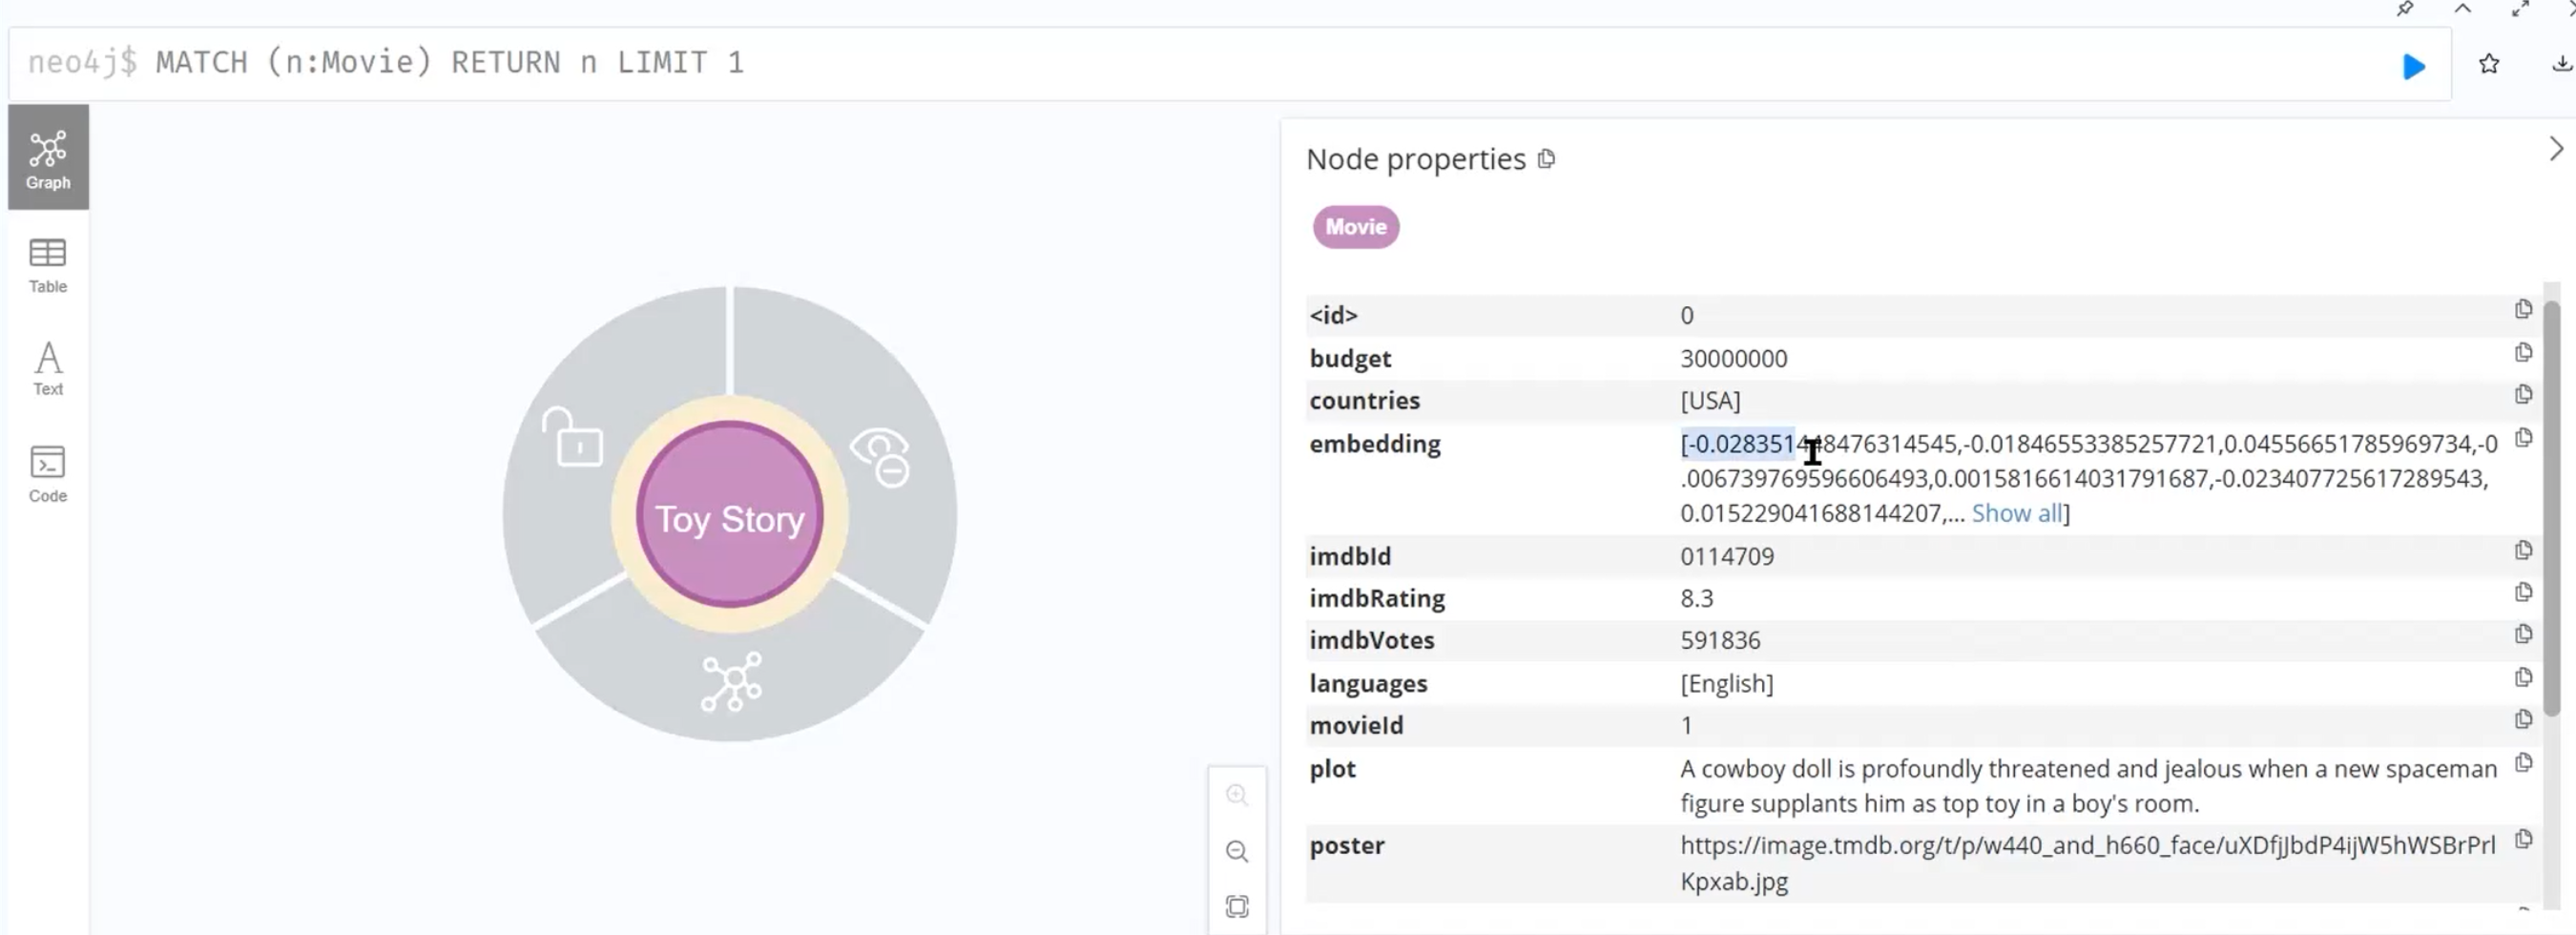

In [ ]:
with driver.session() as session:
    result = session.run("MATCH (m:Movie) WHERE m.plot IS NOT NULL RETURN elementId(m) AS id, m.plot AS plot")
    records = result.data()

    for record in records:
        node_id = record["id"]
        text = record["plot"]
        vector = embedder.embed_query(text)

        session.run("""
        MATCH (m) WHERE elementId(m) = $id
        SET m.embedding = $embedding
        """, {"id": node_id, "embedding": vector})

In [ ]:
# 임베딩을 기반으로 vector index 생성
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "plotindex"
DIMENSION=384

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Movie",
        embedding_property="embedding",
        dimensions=DIMENSION,
        similarity_fn="cosine",
    )

2️⃣ VectorCypher Retriever 사용하기

```
VectorCypherRetriever

- driver (neo4j.Driver) – Neo4j 파이썬 드라이버
- index_name (str) – Vector INDEX 이름
- retrieval_query (str) – 추가 그래프 순회를 위한 쿼리
- embedder (Optional[Embedder]) – 임베딩 모델
```

- 영화(node)에 출연한 배우(Actor) 정보

In [ ]:
# VectorCypherRetriever은 아래와 같이 추가 그래프 순회를 위한 쿼리를 인자로 받는다

from neo4j_graphrag.retrievers import VectorCypherRetriever

Index_NAME = "plotindex"

# 아래의 (node)는 vector index로 검색된 노드를 의미
# 검색된 node의 영화 정보 뿐 아니라 배우 정보까지 찾는 쿼리
retrieval_query = """
MATCH
(actor:Actor)-[:ACTED_IN]->(node)
RETURN
node.title AS movie_title,
node.plot AS movie_plot,
collect(actor.name) AS actors;
"""
retriever = VectorCypherRetriever(
    driver=driver,
    index_name=Index_NAME,
    retrieval_query=retrieval_query,
    embedder=embedder,
)

In [ ]:
# 주만지를 찾기 위한 검색
retriever.search(query_text="Who were the actors in the movie about the magic jungle board game?", top_k=5)

- 영화(node)에 대한 장르(Genre), 배우(Actor) 등 정보

In [ ]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

INDEX_NAME = "plotindex"

# 장르 정보까지 추가
retrieval_query = """
MATCH
(actor:Actor)-[:ACTED_IN]->(node)
RETURN
node.title AS movie_title,
node.plot AS movie_plot, 
collect(actor.name) AS actors;
"""
retriever = VectorCypherRetriever(
    driver,
    index_name=INDEX_NAME,
    retrieval_query=retrieval_query,
    embedder= embedder
)

In [ ]:
# 주만지를 찾기 위한 검색
retriever.search(query_text="Who were the actors in the movie about the magic jungle board game?", top_k=5)

### 3️⃣ GraphRAG 파이프라인 모듈 사용하기

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import RagTemplate, GraphRAG

prompt_template = RagTemplate(
    template="""
        You are a helpful movie assistant. Based on the provided plot-based question and retrieved movie information, identify the most relevant movie and explain it to the user in a clear and concise manner.

        Use the context to include:
        - the movie title
        - a brief plot summary (if available)
        - genre(s)
        - main actor(s)

        If multiple movies match, mention the most likely one and briefly list alternatives.

        Answer the question below naturally and informatively in Korean.

        Question: {query_text}

        Context: {context}

        Answer: """,
    expected_inputs=["context", "query_text"]
)


llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm, prompt_template=prompt_template)

In [ ]:
query = "What is the movie about the magic board game?"
response = graph_rag.search(query_text=query, return_context = True)

In [ ]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)

In [ ]:
query = "A cowboy doll and new spaceman figure in a boy's room?"
response = graph_rag.search(query_text=query, return_context = True)

In [ ]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)